## Imports & Settings

In [1]:
from pathlib import Path
from time import time
import warnings
from collections import Counter
import logging
from ast import literal_eval as make_tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
# import word2vec

In [2]:
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')
np.random.seed(42)

In [3]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

### Paths

In [4]:
sec_path = Path('data', 'sec-filings')
data_path = sec_path / 'data'
ngram_path = data_path / 'ngrams'
model_path = sec_path / 'models' /'baseline'

### Logging Setup

In [5]:
logging.basicConfig(
        filename=sec_path / 'logs' / 'word2vec.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## word2vec

In [6]:
analogies_path = Path('data', 'analogies', 'analogies-en.txt')

### Set up Sentence Generator

In [7]:
NGRAMS = 2

To facilitate memory-efficient text ingestion, the LineSentence class creates a generator from individual sentences contained in the provided text file:

In [8]:
sentence_path = ngram_path  / f'ngrams_{NGRAMS}.txt'
sentences = LineSentence(sentence_path)

### Train word2vec Model

The [gensim.models.word2vec](https://radimrehurek.com/gensim/models/word2vec.html) class implements the skipgram and CBOW architectures introduced above. The notebook [word2vec](../03_word2vec.ipynb) contains additional implementation detail.

In [9]:
start = time()
model = Word2Vec(sentences,
                 sg=1,          # 1 for skip-gram; otherwise CBOW
                 hs=0,          # hierarchical softmax if 1, negative sampling if 0
                 size=300,      # Vector dimensionality
                 window=5,      # Max distance betw. current and predicted word
                 min_count=50,  # Ignore words with lower frequency
                 negative=15,    # noise word count for negative sampling
                 workers=8,     # no threads 
                 iter=1,        # no epochs = iterations over corpus
                 alpha=0.05,   # initial learning rate
                 min_alpha=0.0001 # final learning rate
                ) 
print('Duration:', format_time(time() - start))

Duration: 00:15:04


### Persist model & vectors

In [10]:
model.save((model_path / 'word2vec.model').as_posix())
model.wv.save((model_path / 'word_vectors.bin').as_posix())

### Load model and vectors

In [11]:
model = Word2Vec.load((model_path / 'word2vec.model').as_posix())

In [12]:
wv = KeyedVectors.load((model_path / 'word_vectors.bin').as_posix())

### Get vocabulary

In [13]:
vocab = []
for k, _ in model.wv.vocab.items():
    v_ = model.wv.vocab[k]
    vocab.append([k, v_.index, v_.count])

In [14]:
vocab = (pd.DataFrame(vocab, 
                     columns=['token', 'idx', 'count'])
         .sort_values('count', ascending=False))

In [15]:
vocab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57380 entries, 715 to 42360
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   token   57380 non-null  object
 1   idx     57380 non-null  int64 
 2   count   57380 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [16]:
vocab.head(10)

,token,idx,count
715,million,0,2340243
0,business,1,1700662
2025,december,2,1513533
6,company,3,1490752
171,products,4,1368711
2030,net,5,1253343
139,market,6,1149048
350,including,7,1110482
1611,sales,8,1098312
2240,costs,9,1020383


In [17]:
vocab['count'].describe(percentiles=np.arange(.1, 1, .1)).astype(int)

count      57380
mean        4526
std        35237
min           50
10%           60
20%           75
30%           96
40%          127
50%          176
60%          262
70%          440
80%          940
90%         3670
max      2340243
Name: count, dtype: int64

### Evaluate Analogies

In [18]:
def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='total', ['correct', 'incorrect', 'average']].squeeze().tolist()

In [19]:
detailed_accuracy = model.wv.accuracy(analogies_path.as_posix(), case_insensitive=True)

In [20]:
summary = accuracy_by_category(detailed_accuracy)

                       category  correct  incorrect   average
10  gram6-nationality-adjective      416        396  0.512315
12                 gram8-plural      225        375  0.375000
7             gram3-comparative      247        623  0.283908
9      gram5-present-participle      104        276  0.273684
14                        total     2077       5549  0.272358
13           gram9-plural-verbs       77        229  0.251634
2                 city-in-state      729       2189  0.249829
6                gram2-opposite       45        165  0.214286
11             gram7-past-tense      122        528  0.187692
5     gram1-adjective-to-adverb       57        249  0.186275
8             gram4-superlative       42        198  0.175000
0      capital-common-countries        9        101  0.081818
1                 capital-world        1         41  0.023810
3                      currency        3        149  0.019737
4                        family        0         30  0.000000


In [21]:
def eval_analogies(w2v, max_vocab=15000):
    accuracy = w2v.wv.accuracy(analogies_path,
                               restrict_vocab=15000,
                               case_insensitive=True)
    return (pd.DataFrame([[c['section'],
                        len(c['correct']),
                        len(c['incorrect'])] for c in accuracy],
                      columns=['category', 'correct', 'incorrect'])
          .assign(average=lambda x: 
                  x.correct.div(x.correct.add(x.incorrect))))  

In [22]:
def total_accuracy(w2v):
    df = eval_analogies(w2v)
    return df.loc[df.category == 'total', ['correct', 'incorrect', 'average']].squeeze().tolist()

In [23]:
accuracy = eval_analogies(model)
accuracy

,category,correct,incorrect,average
0,capital-common-countries,2,10,0.166667
1,capital-world,0,0,NaN
2,city-in-state,244,480,0.337017
3,currency,3,49,0.057692
4,family,0,0,NaN
5,gram1-adjective-to-adverb,40,170,0.190476
6,gram2-opposite,20,70,0.222222
7,gram3-comparative,223,377,0.371667
8,gram4-superlative,24,66,0.266667
9,gram5-present-participle,82,224,0.267974


### Validate Vector Arithmetic

In [24]:
sims=model.wv.most_similar(positive=['iphone'], restrict_vocab=15000)
print(pd.DataFrame(sims, columns=['term', 'similarity']))

             term  similarity
0            ipad    0.676419
1         android    0.642430
2             app    0.620278
3      smartphone    0.603889
4     smartphones    0.601604
5           apple    0.566086
6      mobile_app    0.558745
7     smart_phone    0.553762
8        handsets    0.535715
9  mobile_devices    0.533918


In [25]:
analogy = model.wv.most_similar(positive=['france', 'london'], 
                                negative=['paris'], 
                                restrict_vocab=15000)
print(pd.DataFrame(analogy, columns=['term', 'similarity']))

             term  similarity
0         germany    0.580489
1     netherlands    0.534376
2  united_kingdom    0.533495
3           italy    0.525086
4         belgium    0.517875
5       australia    0.506363
6          sweden    0.494862
7           spain    0.490362
8    south_africa    0.488136
9  germany_france    0.482264


### Check similarity for random words

In [26]:
VALID_SET = 5  # Random set of words to get nearest neighbors for
VALID_WINDOW = 100  # Most frequent words to draw validation set from
valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)
similars = pd.DataFrame()

for id in sorted(valid_examples):
    word = vocab.loc[id, 'token']
    similars[word] = [s[0] for s in model.wv.most_similar(word)]
similars

,paradigm,fundamentally,patient,quality,percent
0,paradigms,transform,patients,cleanliness,percent_percent
1,personalized_medicine,transforming,clinician,freshness,percentage
2,revolutionized,reshaping,physician,high_quality,total
3,adoptive,way,outpatients,trustworthiness,mwh_mwh
4,servicenow,paradigms,hospital,dependability,approximately
5,revolutionize,embracing,givers,consistency,basis_points
6,mx_icp,embrace,care,timeliness,approximatel_y
7,monogenic_diseases,alter,ophthalmologist,reliability,yr
8,cellular_immunotherapy,radically,hospital_readmissions,responsiveness,respectively
9,anemia_ckd,profoundly,inpatient,friendliness,represented


## Continue Training

In [ ]:
accuracies = [summary]
best_accuracy = summary[-1]
for i in range(1, 20):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    detailed_accuracy = model.wv.accuracy(analogies_path)
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print(f'{i:02} | Duration: {format_time(time() - start)} | Accuracy: {accuracies[-1][-1]:.2%} ')
    if accuracies[-1][-1] > best_accuracy:
        model.save((model_path / f'word2vec_{i:02}.model').as_posix())
        model.wv.save((model_path / f'word_vectors_{i:02}.bin').as_posix())
        best_accuracy = accuracies[-1][-1]
    (pd.DataFrame(accuracies, 
                 columns=['correct', 'wrong', 'average'])
     .to_csv(model_path / 'accuracies.csv', index=False))
model.wv.save((model_path / 'word_vectors_final.bin').as_posix())

### Sample Output


|Epoch|Duration| Accuracy|
|---|---|---|
01 | 00:14:00 | 31.64% | 
02 | 00:14:21 | 31.72% | 
03 | 00:14:34 | 33.65% | 
04 | 00:16:11 | 34.03% | 
05 | 00:13:51 | 33.04% | 
06 | 00:13:46 | 33.28% | 
07 | 00:13:51 | 33.10% | 
08 | 00:13:54 | 34.11% | 
09 | 00:13:54 | 33.70% | 
10 | 00:13:55 | 34.09% | 
11 | 00:13:57 | 35.06% | 
12 | 00:13:38 | 33.79% | 
13 | 00:13:26 | 32.40% | 

In [30]:
(pd.DataFrame(accuracies, 
             columns=['correct', 'wrong', 'average'])
 .to_csv(model_path / 'accuracies.csv', index=False))

In [31]:
best_model = Word2Vec.load((model_path / 'word2vec_11.model').as_posix())

In [32]:
detailed_accuracy = best_model.wv.accuracy(analogies_path.as_posix(), case_insensitive=True)

In [33]:
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect   average
10  gram6-nationality-adjective      462        350  0.568966
2                 city-in-state     1211       1707  0.415010
12                 gram8-plural      243        357  0.405000
14                        total     2674       4952  0.350643
7             gram3-comparative      287        583  0.329885
9      gram5-present-participle      106        274  0.278947
13           gram9-plural-verbs       75        231  0.245098
5     gram1-adjective-to-adverb       61        245  0.199346
11             gram7-past-tense      126        524  0.193846
8             gram4-superlative       46        194  0.191667
6                gram2-opposite       40        170  0.190476
0      capital-common-countries       14         96  0.127273
1                 capital-world        1         41  0.023810
3                      currency        2        150  0.013158
4                        family        0         30  0.000000
Base Acc

In [34]:
cat_dict = {'capital-common-countries':'Capitals',
            'capital-world':'Capitals RoW',
            'city-in-state':'City-State',
            'currency':'Currency',
            'family':'Famliy',
            'gram1-adjective-to-adverb':'Adj-Adverb',
            'gram2-opposite':'Opposite',
            'gram3-comparative':'Comparative',
            'gram4-superlative':'Superlative',
            'gram5-present-participle':'Pres. Part.',
            'gram6-nationality-adjective':'Nationality',
            'gram7-past-tense':'Past Tense',
            'gram8-plural':'Plural',
            'gram9-plural-verbs':'Plural Verbs',
            'total':'Total'}

In [35]:
results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in detailed_accuracy]
results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
results['category'] = results.category.map(cat_dict)
results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
results = results.rename(columns=str.capitalize).set_index('Category')
total = results.loc['Total']
results = results.drop('Total')

In [36]:
most_sim = best_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,women,0.412746
1,couples,0.386341
2,sperling,0.358182
3,kids,0.355766
4,elite,0.354562
5,college,0.353110
6,boston,0.351908
7,sullivan,0.346279
8,holbrook,0.346174
9,stylish,0.342540


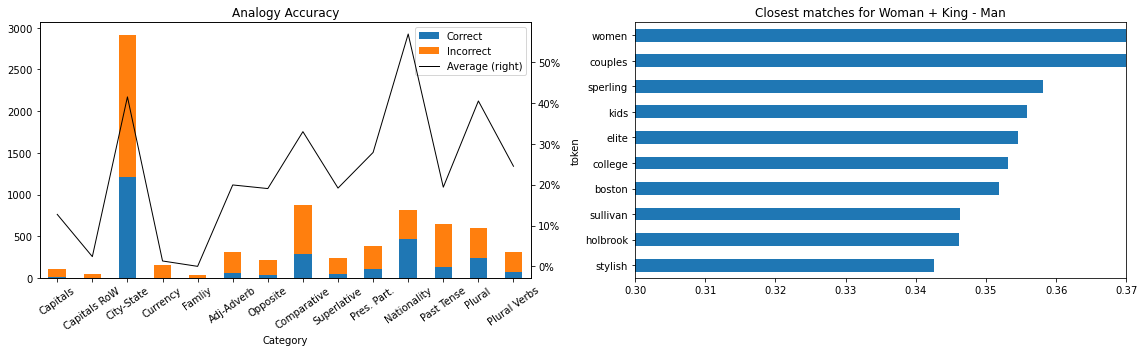

In [37]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=2)

axes[0] = results.loc[:, ['Correct', 'Incorrect']].plot.bar(stacked=True, ax=axes[0]
                                                           , title='Analogy Accuracy')
ax1 = results.loc[:, ['Average']].plot(ax=axes[0], secondary_y=True, lw=1, c='k', rot=35)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

(pd.DataFrame(most_sim, columns=['token', 'similarity'])
 .set_index('token').similarity
 .sort_values().tail(10).plot.barh(xlim=(.3, .37), ax=axes[1], title='Closest matches for Woman + King - Man'))
fig.tight_layout()
# fig.savefig('figures/w2v_sec_evaluation', dpi=300);